# University of Chicago Assignment 5 Exploring Decision Tree Classifier

In [1]:
path = r"C:\Users\gauth\Desktop\PGPDM\decisiontrees"

Importing a series of packages

In [3]:
import pandas as pd 
import numpy as np 
#visualization
import matplotlib.pyplot as plt
import seaborn as sns
#to randomly split data into train and test
from sklearn.model_selection import train_test_split
#Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
#evaluation metrics
from sklearn.metrics import roc_curve,auc,f1_score,roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report,accuracy_score
#gridsearch
from sklearn.model_selection import GridSearchCV
#decision graphs
from sklearn.tree import export_graphviz
import graphviz
from pydotplus import graph_from_dot_data
%matplotlib inline

Setting seed. This helps us to replicate the same output during multiple runs further down the code wherever random sampling happens

In [4]:
seed = 45

In [5]:
df = pd.read_csv(path+"\\bill_authentication.csv")

In [58]:
df.shape

(1372, 4)

The goal here is to predict Class using the other four columns

In [5]:
df.columns

Index(['Variance', 'Skewness', 'Curtosis', 'Entropy', 'Class'], dtype='object')

In [6]:
df.head()

,Variance,Skewness,Curtosis,Entropy,Class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [41]:
pd.crosstab(df.Class,columns="count").apply(lambda r: (r/r.sum())*100)

col_0,count
Class,
0,55.539359
1,44.460641


The class variable is pretty evenly balanced

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


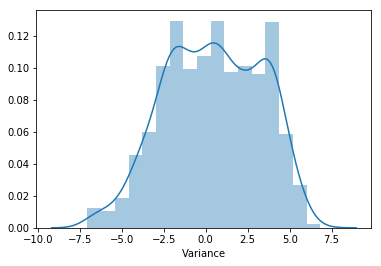

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


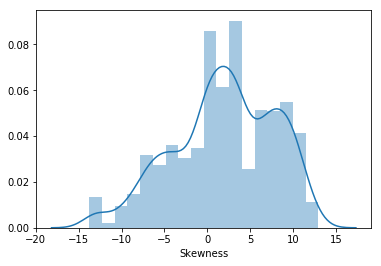

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


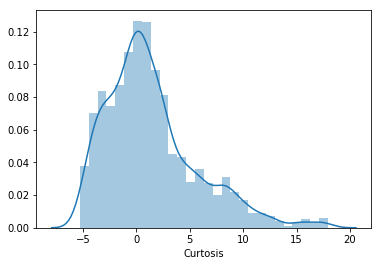

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


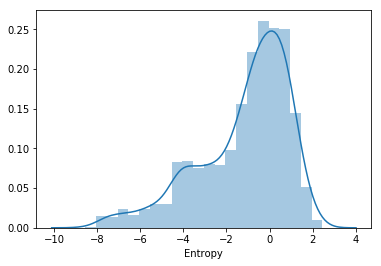

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


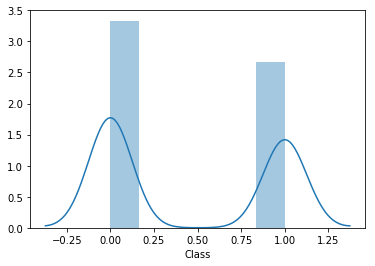

In [26]:
for columns in df.columns:
    sns.distplot(df[columns])
    plt.show()

Splitting the data into test and train

In [6]:
X = df.drop('Class', axis =1)
Y = df.pop('Class')

In [7]:
xtrain, xtest, ytrain, ytest = train_test_split(X,Y, test_size=0.2,random_state=seed)
print (xtrain.shape, ytrain.shape)
print (xtest.shape, ytest.shape)

(1097, 4) (1097,)
(275, 4) (275,)


Building a default Decision Tree Classifier without changing hyperparameter

In [8]:
tree = DecisionTreeClassifier(random_state=seed)
tree.fit(xtrain,ytrain)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=45,
            splitter='best')

By default, the ciriteria used for separation is Gini index.

Gini is computed using the formula 1- (P(Class =0)^2 + P(Class=1)^2) . At the 
first node, all variables are looked at and Gini value for these wrt to the
class variable in calculated. The variable with the lowest gini value gives the 
best separation is the idea. This will the root node and the same thing happens
for all the other variables

In [9]:
ypred= tree.predict(xtest)

The confusion matrix gives you [TN, FP, FN, TP]. 
Precision is defined as TP/TP+FP . How many did I get right of my predictions .
Recall is defined as TP/TP+FN . How many of the actual rights did I get right.

Ideally we would want a model to have high precision and high recall.
I read the optimal tradeoff between them is illustrated by the F1 score.
The F1 score is the harmonic mean of precision and recall.
Harmonic mean is taken because precision and recall have different denominators,
and to average them, they have to be inverted, averaged and inverted again.


Below I am writing a function to measure F1score, precision, recall and print the confusion 
matrix

In [10]:
def mtrcs(act,pred):
    print('\n Accuracy', accuracy_score(act,pred))
    print('\n F1 Score', f1_score(act,pred))
    print('\n Classification Report \n', classification_report(act,pred))
    print('\n Confusion Matrix \n', confusion_matrix(act,pred))

mtrcs(ytest,ypred)


 Accuracy 0.9890909090909091

 F1 Score 0.9855072463768114

 Classification Report 
              precision    recall  f1-score   support

          0       0.99      0.99      0.99       171
          1       0.99      0.98      0.99       104

avg / total       0.99      0.99      0.99       275


 Confusion Matrix 
 [[170   1]
 [  2 102]]


The prediction looks good as almost every metric is in the high 90's . We have only 3 errors out of 275 cases, which gives us the 98.9 accuracy. Accuracy needs to be dealt with carefully in imbalanced classes and that is why we need precision and recall, but siunce this data is evenly balanced, a good accuracy means a good model. We see that other metrics are also high , and FN and FP are very low

In [11]:
dot_data = export_graphviz(tree, filled=True, rounded=True, feature_names=xtest.columns, out_file=None)

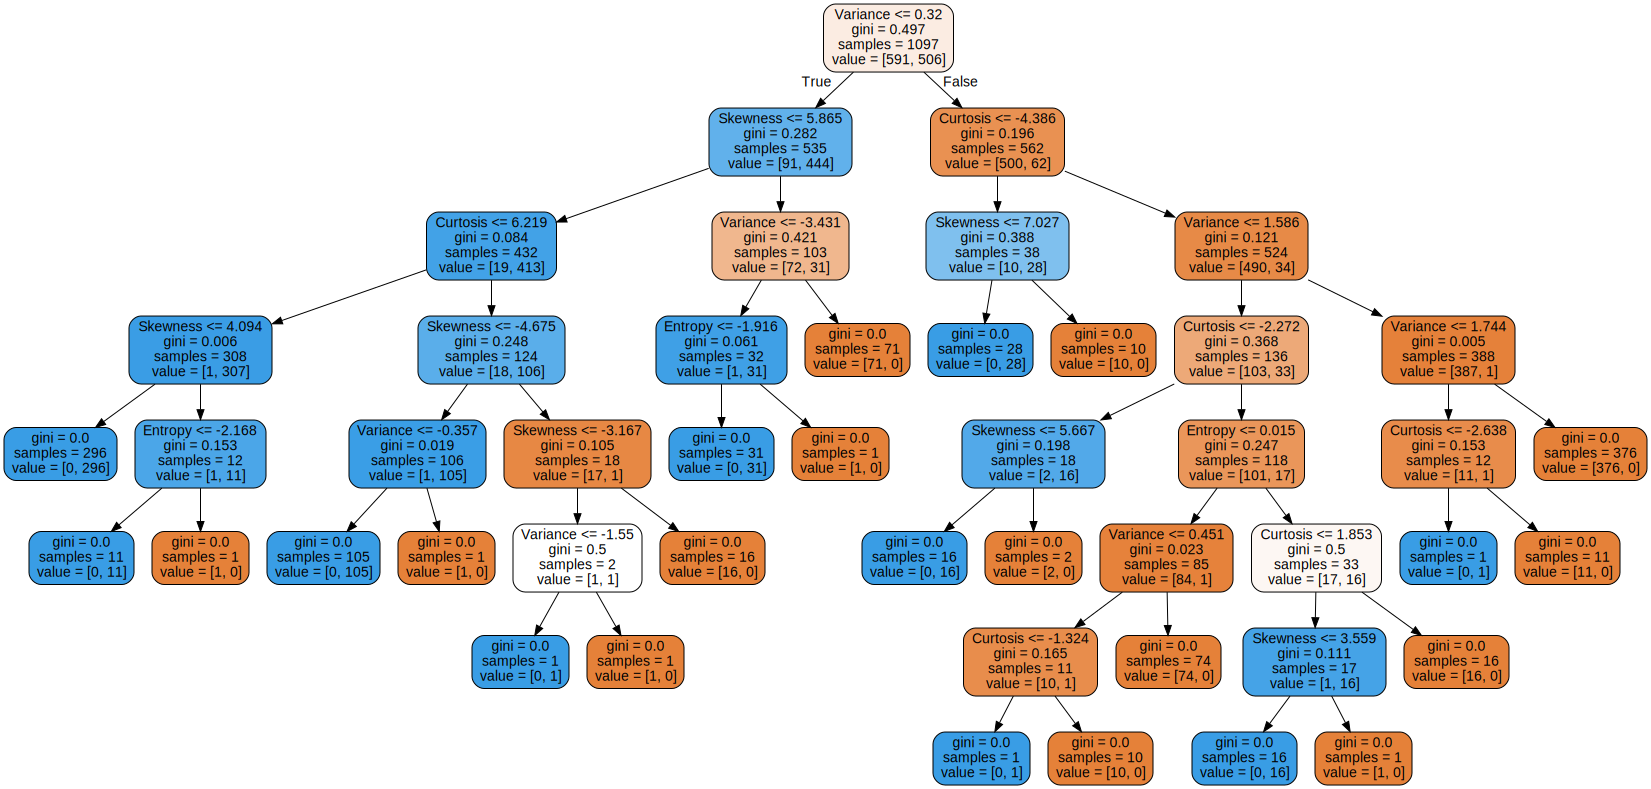

In [12]:
graphviz.Source(dot_data)

## Exploring Grid Search to tune hyperparamaters

In [13]:
parameters = {'min_samples_split' : [2,10,50,100,150],
              'max_depth' : range(1,20,2),
              'criterion' : ['entropy','gini']
              }

In [14]:
grid = GridSearchCV(DecisionTreeClassifier(),parameters, cv=5, n_jobs =-1)

In [15]:
grid.fit(xtrain,ytrain)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'min_samples_split': [2, 10, 50, 100, 150], 'max_depth': range(1, 20, 2), 'criterion': ['entropy', 'gini']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [16]:
grid.best_params_

{'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 2}

In [17]:
final_model = grid.best_estimator_
final_model.fit(xtrain,ytrain)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=15,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [18]:
grid_pred= final_model.predict(xtest)

mtrcs(ytest,grid_pred)


 Accuracy 0.9890909090909091

 F1 Score 0.9853658536585366

 Classification Report 
              precision    recall  f1-score   support

          0       0.98      1.00      0.99       171
          1       1.00      0.97      0.99       104

avg / total       0.99      0.99      0.99       275


 Confusion Matrix 
 [[171   0]
 [  3 101]]


The Grid Search function has implemented every combination of the range of parameters I had given and has figured out that Gini index with max depth of 15 and min sample split of 1 gives the best score

We observe that accuracy is actually the same as the plain vanilla decision tree.Let's plot the tree and see what is happening 

In [19]:
dot_data = export_graphviz(final_model, filled=True, rounded=True, feature_names=xtest.columns, out_file=None)

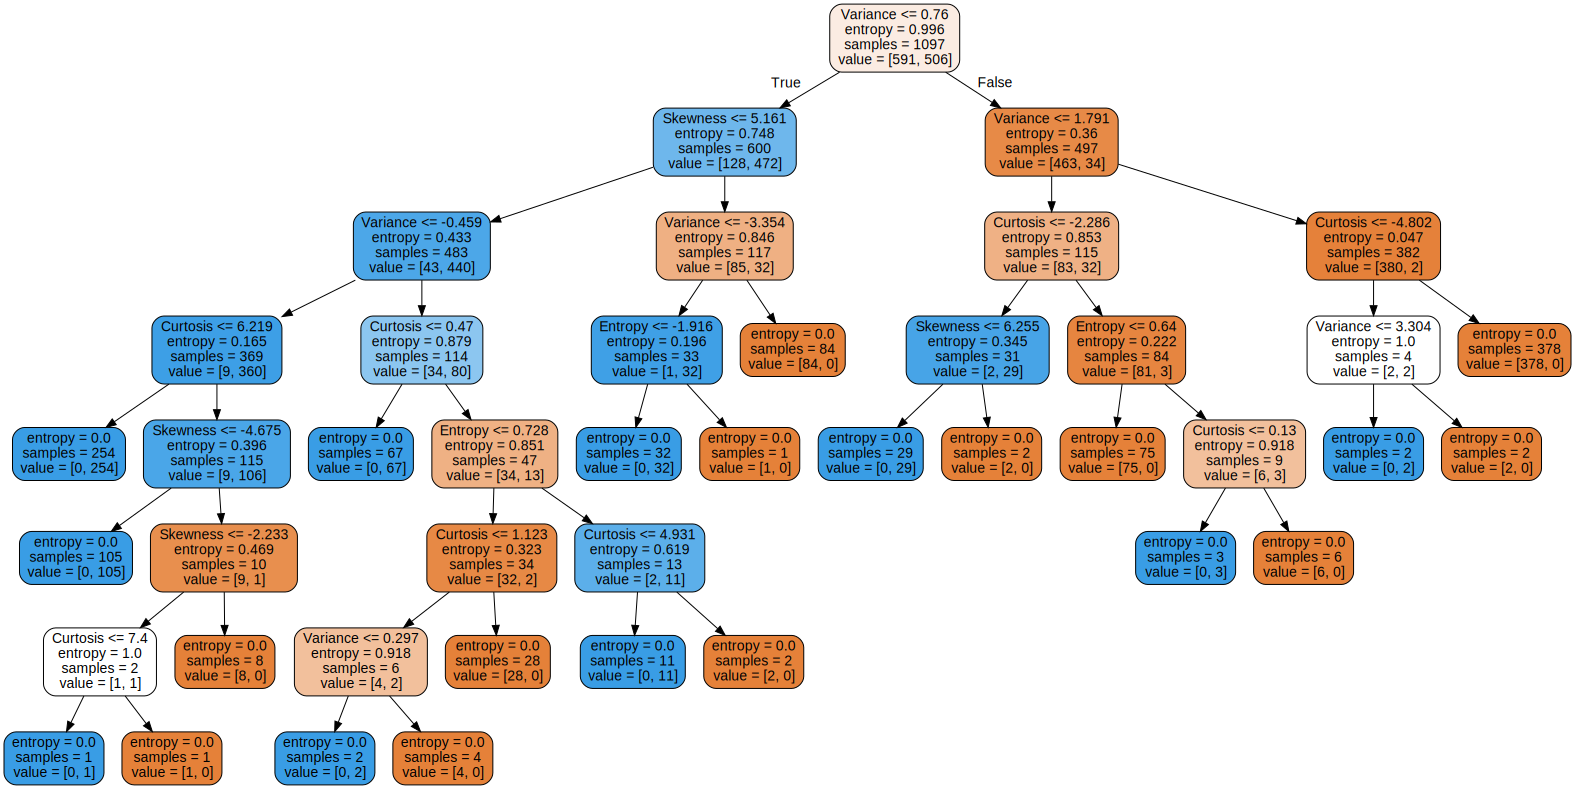

In [20]:
graphviz.Source(dot_data)

Given that this is a small dataset, we might not need to prune the tree and limit the growth of a tree,but in situations where datasets are huge, cutting out the tree based on min_sample_split might help with reducing runtime and also overfitting